In [1]:
import cantera as ct
from spitfire import ChemicalMechanismSpec, Flamelet
import matplotlib.pyplot as plt
import numpy as np
from os.path import abspath, join

In [8]:
sol = ct.Solution('h2-burke.xml', 'h2-burke')

Tair = 1200.
pressure = 101325.
zstoich = 0.1
chi_max = 1.e3
npts_interior = 32

k1mult_list = [0.02, 0.1, 0.2, 1.0, 10.0, 100.0]
sol_dict = dict()

max_time = 0.
max_temp = 0.

A0_original = np.copy(sol.reaction(0).rate.pre_exponential_factor)

for i, k1mult in enumerate(k1mult_list):
    print(f'running {k1mult:.2f}A ...')
    r0 = sol.reaction(0)
    new_rate = ct.Arrhenius(k1mult * A0_original,
                            r0.rate.temperature_exponent,
                            r0.rate.activation_energy)
    new_rxn = ct.ElementaryReaction(r0.reactants, r0.products)
    new_rxn.rate = new_rate
    sol.modify_reaction(0, new_rxn)

    m = ChemicalMechanismSpec.from_solution(sol)
    air = m.stream(stp_air=True)
    air.TP = Tair, pressure
    fuel = m.mix_fuels_for_stoich_mixture_fraction(m.stream('X', 'H2:1'), m.stream('X', 'N2:1'), zstoich, air)
    fuel.TP = 300., pressure

    ft = Flamelet(mech_spec=m,
                  pressure=pressure,
                  oxy_stream=air,
                  fuel_stream=fuel,
                  max_dissipation_rate=chi_max,
                  grid_points=npts_interior + 2,
                  grid_cluster_intensity=4.,
                  initial_condition='unreacted')

    output = ft.integrate_to_steady(first_time_step=1.e-9)

    t = output.time_grid * 1.e3
    z = output.mixture_fraction_grid
    T = output['temperature']
    OH = output['mass fraction OH']
    max_time = max([max_time, np.max(t)])
    max_temp = max([max_temp, np.max(T)])

    sol_dict[k1mult] = (i, t, z, T, OH)
    
print('done')

running 0.02A ...
running 0.10A ...
running 0.20A ...
running 1.00A ...
running 10.00A ...
running 100.00A ...
done


<IPython.core.display.Javascript object>


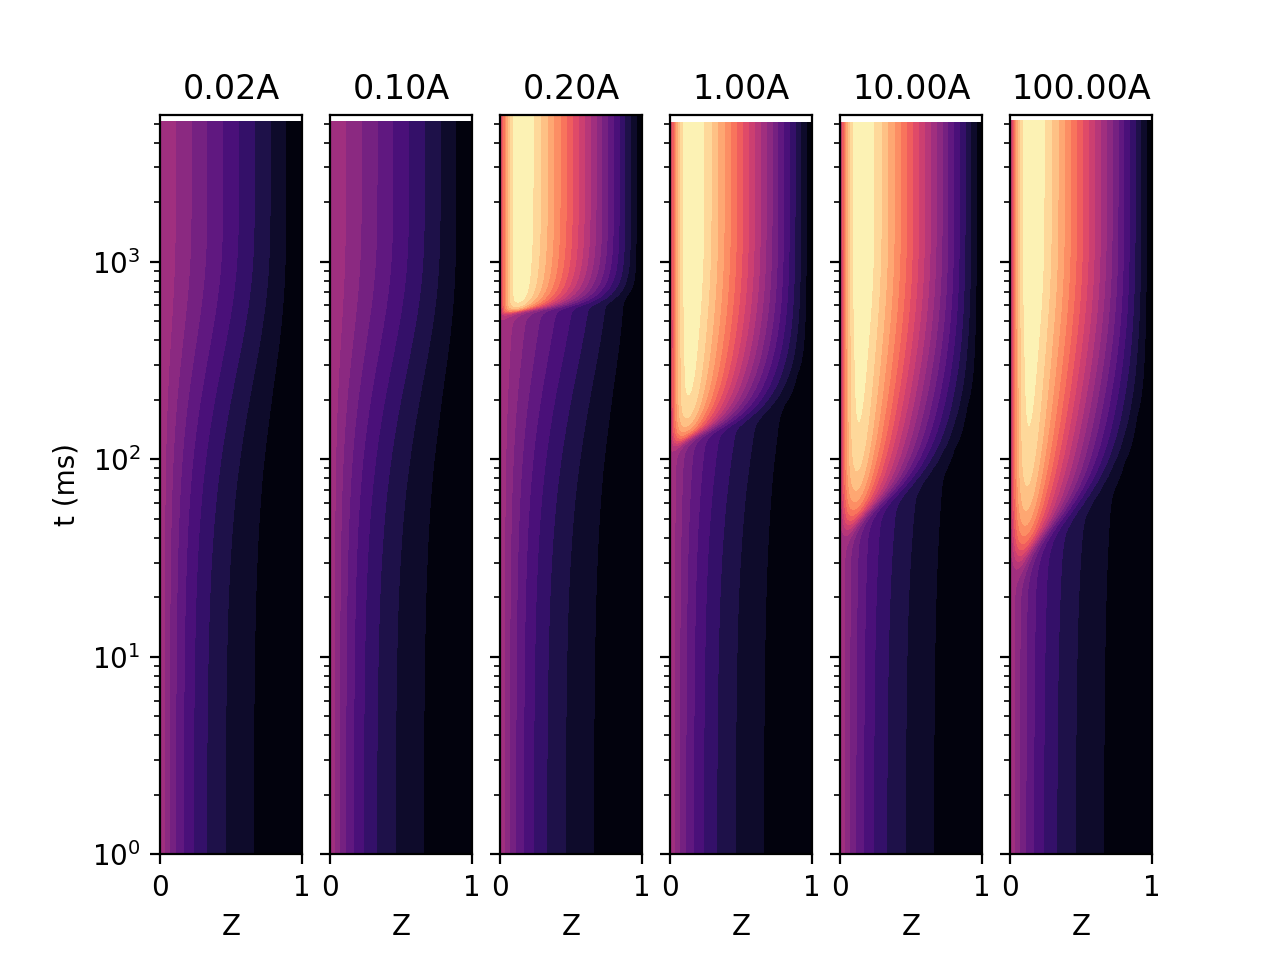

Temperature profiles


In [9]:
%matplotlib notebook
fig, axarray = plt.subplots(1, len(k1mult_list), sharex=True, sharey=True)

print('Temperature profiles')

for k1mult in k1mult_list:
    sol = sol_dict[k1mult]
    axarray[sol[0]].contourf(sol[2], sol[1] * 1.e3, sol[3],
                             cmap=plt.get_cmap('magma'),
                             levels=np.linspace(300., max_temp, 20))
    axarray[sol[0]].set_title(f'{k1mult:.2f}A')
    axarray[sol[0]].set_xlim([0, 1])
    axarray[sol[0]].set_ylim([1.e0, max_time * 1.e3])
    axarray[sol[0]].set_yscale('log')
    axarray[sol[0]].set_xlabel('Z')

axarray[0].set_ylabel('t (ms)')
plt.show()

<IPython.core.display.Javascript object>


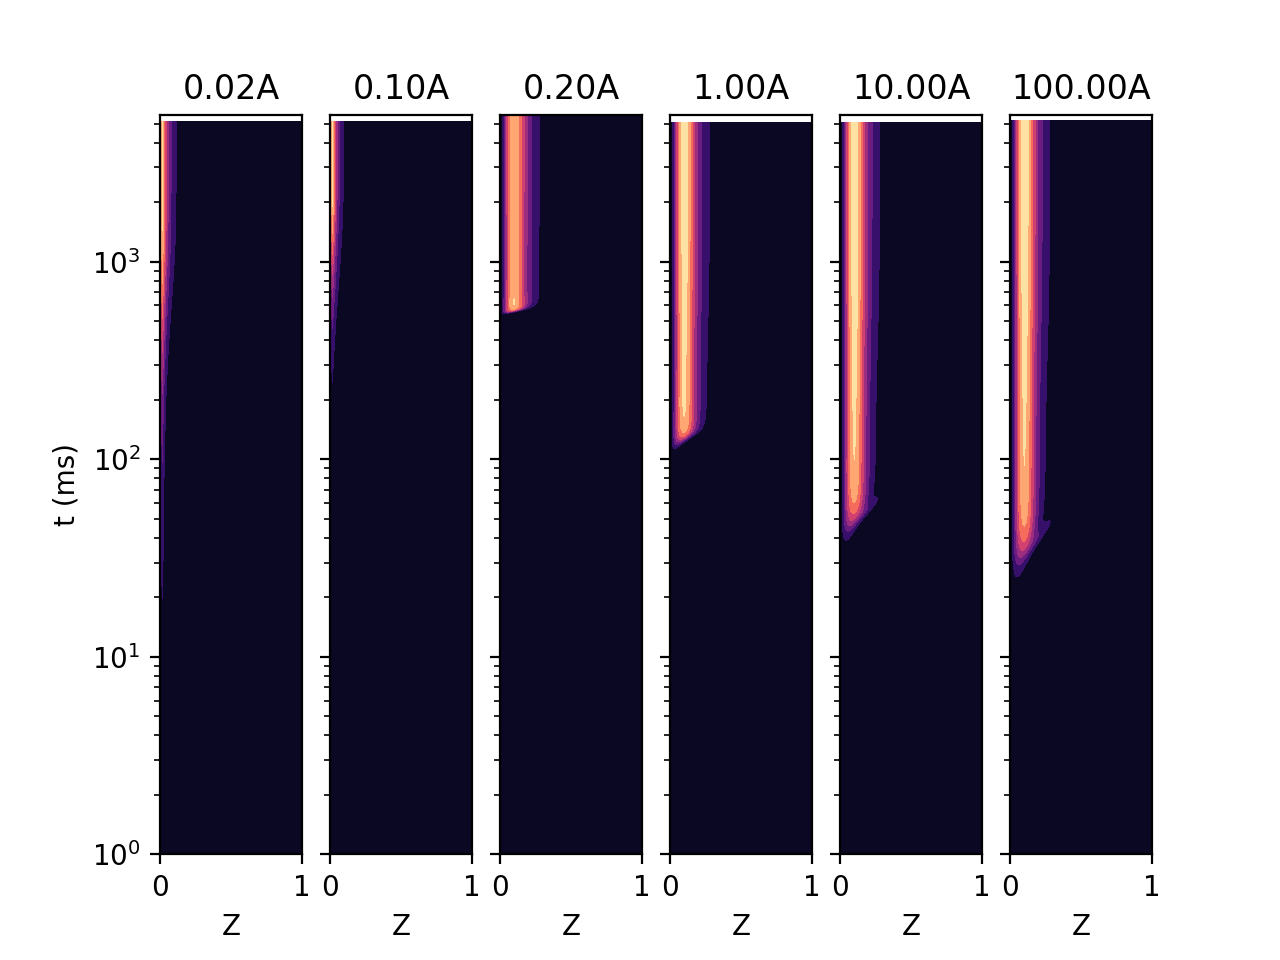

Mass fraction OH profiles


In [12]:
%matplotlib notebook
fig, axarray = plt.subplots(1, len(k1mult_list), sharex=True, sharey=True)

print('Mass fraction OH profiles')

for k1mult in k1mult_list:
    sol = sol_dict[k1mult]
    axarray[sol[0]].contourf(sol[2], sol[1] * 1.e3, sol[4],
                             cmap=plt.get_cmap('magma'))
    axarray[sol[0]].set_title(f'{k1mult:.2f}A')
    axarray[sol[0]].set_xlim([0, 1])
    axarray[sol[0]].set_ylim([1.e0, max_time * 1.e3])
    axarray[sol[0]].set_yscale('log')
    axarray[sol[0]].set_xlabel('Z')

axarray[0].set_ylabel('t (ms)')
plt.show()